# About

This is a continuation of [Lithology classification using Hugging Face, part 1](https://jmp75.github.io/work-blog/hugging-face/nlp/lithology/2022/06/01/lithology-classification-hugging-face.html).

We saw in the previous post that the Namoi lithology logs data had their primary (major) lithology mostly completed. A substantial proportion had the label `None` nevertheless, despite descriptions that looked like they would obviously lead to a categorisation. There were many labels, with a long-tailed frequency histogram.

The aim of this post is (was) to get a classification training happening.

__Spoiler alert: it won't__. Almost.

Rather than write a post after the fact pretending it was a totally smooth journey, the following walktrough _deliberately_ keeps and highlights issues, albeit succinctly. **Don't** jump to the conclusion that we will not get there eventually, or that Hugging Face is not good. When you adapt prior work to your own use case, you **will** likely stumble, so this post will make you feel in good company.

# Kernel installation

The previous post was about data exploration and used mostly facilities such as pandas, not any deep learning related material. This post will, so we need to install Hugging Face. I did bump into a couple of issues while trying to get an environment going. I will not give the full grubby details, but highlight upfront a couple of things:

* Do create a new dedicated conda environment for your work with Hugging Face, even if you already have an environment with e.g. pytorch you'd like to reuse.
* The version 4.11.3 of HF `transformers` on the conda channel `huggingface`, at the time of writing, has a [bug](https://github.com/nlp-with-transformers/notebooks/issues/31). You should install the packages from the `conda-forge` channel.

In a nutshell, for Linux:

```sh
myenv=hf
mamba create -n $myenv python=3.9 -c conda-forge
mamba install -n $myenv --yes ipykernel matplotlib sentencepiece scikit-learn -c conda-forge
mamba install -n $myenv --yes pytorch=1.11 -c pytorch -c nvidia -c conda-forge
mamba install -n $myenv --yes torchvision torchaudio -c pytorch -c nvidia -c conda-forge
mamba install -n $myenv --yes -c conda-forge datasets transformers
conda activate $myenv
python -m ipykernel install --user --name $myenv --display-name "Hugging Face"
```

and in Windows:

```bat
set myenv=hf
mamba create -n %myenv% python=3.9 -c conda-forge
mamba install -n %myenv% --yes ipykernel matplotlib sentencepiece scikit-learn -c conda-forge
mamba install -n %myenv% --yes pytorch=1.11 -c pytorch -c nvidia -c conda-forge
mamba install -n %myenv% --yes torchvision torchaudio -c pytorch -c nvidia -c conda-forge
mamba install -n %myenv% --yes -c conda-forge datasets transformers
conda activate %myenv%
python -m ipykernel install --user --name %myenv% --display-name "Hugging Face"
```


# Walkthrough

Let's get on with all the imports upfront (not obvious, mind you, but after the fact...)

In [1]:
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from pathlib import Path
from datasets import ClassLabel
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score
from collections import Counter

# Some column string identifiers
MAJOR_CODE = "MajorLithCode"
MAJOR_CODE_INT = "MajorLithoCodeInt"  # We will create a numeric representation of labels, which is (I think?) required by HF.
MINOR_CODE = "MinorLithCode"
DESC = "Description"

/home/abcdef/miniconda/envs/hf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<AxesSubplot:xlabel='token'>

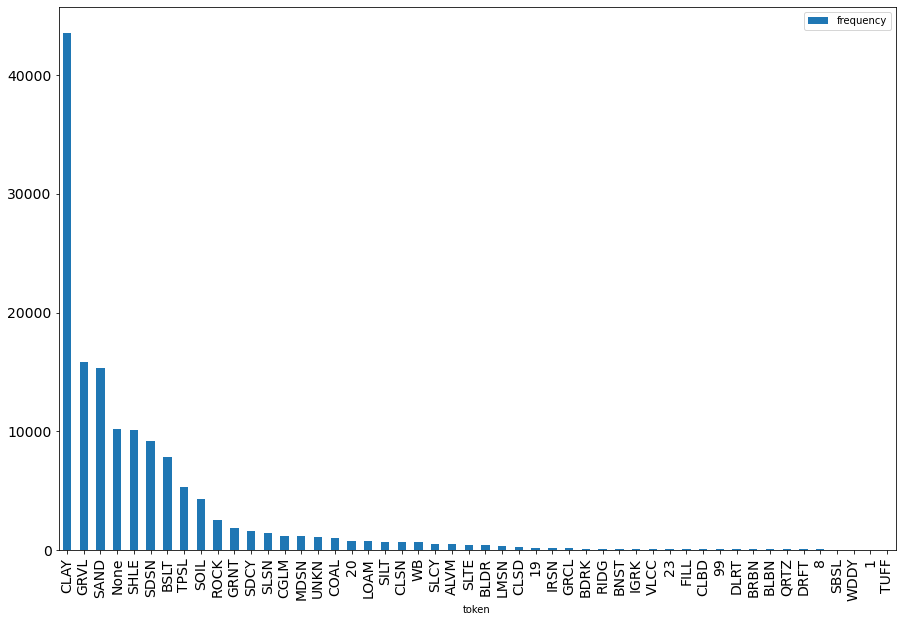

In [2]:
fn = Path("~").expanduser() / "data/ela/shp_namoi_river/NGIS_LithologyLog.csv"
litho_logs = pd.read_csv(
    fn, dtype={"FromDepth": str, "ToDepth": str, MAJOR_CODE: str, MINOR_CODE: str}
)

# To avoid importing from the ela package, copy a couple of functions:
# from ela.textproc import token_freq, plot_freq


def token_freq(tokens, n_most_common=50):
    list_most_common = Counter(tokens).most_common(n_most_common)
    return pd.DataFrame(list_most_common, columns=["token", "frequency"])


def plot_freq(dataframe, y_log=False, x="token", figsize=(15, 10), fontsize=14):
    """Plot a sorted histogram of work frequencies

    Args:
        dataframe (pandas dataframe): frequency of tokens, typically with colnames ["token","frequency"]
        y_log (bool): should there be a log scale on the y axis
        x (str): name of the columns with the tokens (i.e. words)
        figsize (tuple):
        fontsize (int):

    Returns:
        barplot: plot

    """
    p = dataframe.plot.bar(x=x, figsize=figsize, fontsize=fontsize)
    if y_log:
        p.set_yscale("log", nonposy="clip")
    return p


litho_classes = litho_logs[MAJOR_CODE].values
df_most_common = token_freq(litho_classes, 50)
plot_freq(df_most_common)

## Imbalanced data sets

From the histogram above, it is pretty clear that labels are also not uniform an we have a class imbalance. Remember to skim [Lithology classification using Hugging Face, part 1](https://jmp75.github.io/work-blog/hugging-face/nlp/lithology/2022/06/01/lithology-classification-hugging-face.html) for the initial data exploration if you have not done so already.

For the sake of the exercise in this post, I will reduce arbitrarily the number of labels used in this post, by just "forgetting" the less represented classes.

There are many resources about class imbalances. One of them is [8 Tactics to combat imbalanced classes in your machine learning dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset)

Let's see what labels we may want to keep for this post:


In [3]:
def sample_desc_for_code(major_code, n=50, seed=None):
    is_code = litho_logs[MAJOR_CODE] == major_code
    coded = litho_logs.loc[is_code][DESC]
    if seed is not None:
        np.random.seed(seed)
    return coded.sample(n=50)

In [4]:
sample_desc_for_code("UNKN", seed=123)

134145     (UNKNOWN), NO SAMPLE COLLECTED DUE TO WATER LOSS
134715    (UNKNOWN); COULD NOT BE LOGGED BECAUSE NO CUTT...
122303                                          GREY SHALEY
133856                                              NOMINAL
134378                                                 None
133542                                              DRILLER
122258                                        WATER BEARING
127916                                         WATER SUPPLY
133676                                              DRILLER
134399                                              DRILLER
134052                                              DRILLER
128031                         VERY SANDY STONES SOME LARGE
134140                                       SAMPLE MISSING
122282                              REDDISH YELLOW VOLCANIC
133623                                    WHITE CRYSTALLINE
134505                                              MISSING
133694                                  

The "unknown" category is rather interesting in fact, and worth keeping as a valid class.

## Subsetting

Let's keep "only" the main labels, for the sake of this exercise. We will remove None however, despite its potential interest. We will (hopefully) revisit this in another post.

In [5]:
labels_kept = df_most_common["token"][:17].values  # 17 first classes somewhat arbitraty
labels_kept = labels_kept[labels_kept != "None"]
labels_kept

array(['CLAY', 'GRVL', 'SAND', 'SHLE', 'SDSN', 'BSLT', 'TPSL', 'SOIL',
       'ROCK', 'GRNT', 'SDCY', 'SLSN', 'CGLM', 'MDSN', 'UNKN', 'COAL'],
      dtype=object)

In [6]:
kept = [x in labels_kept for x in litho_classes]
litho_logs_kept = litho_logs[kept].copy()  # avoid warning messages down the track.
litho_logs_kept.sample(10)

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType,OgcFidTemp
70655,526412,10072593,GW031851.1.1,None,UNK,53.94,59.13,None,None,CLAY,NaN,CLAY SANDY,UNK,1,9308381
7173,64072,10043001,GW001815.1.1,None,UNK,31.39,44.5,None,None,SHLE,NaN,SHALE,UNK,1,8732384
30076,197788,10152523,GW099036.1.1,None,UNK,181.0,228.0,None,None,SHLE,NaN,"SHALE: GREY, FINE",UNK,1,8870150
93967,701859,10105392,GW031140.1.1,None,UNK,0.0,8.84,None,None,SOIL,NaN,SOIL CLAY,UNK,1,9327759
115538,803595,10099300,GW970770.1.1,None,UNK,36.6,38.1,None,None,SAND,NaN,"SAND; FINE TO COARSE, BROWN",UNK,1,9435886
107173,762000,10122945,GW018629.1.1,None,UNK,72.54,74.37,None,None,SDSN,NaN,SANDSTONE YELLOW HARD,UNK,1,9389679
106769,760370,10111007,GW026576.1.1,None,UNK,65.23,71.32,None,None,SDSN,NaN,SANDSTONE WATER SUPPLY,UNK,1,9388007
13553,114744,10116235,GW022175.1.1,None,UNK,37.8,39.01,None,None,GRVL,NaN,GRAVEL FINE-COARSE,UNK,1,8784472
142398,971715,10074454,GW901230.1.1,None,UNK,20.0,24.0,None,None,GRVL,NaN,GRAVEL,UNK,1,9567221
9664,85061,10043586,GW011521.1.1,None,UNK,12.19,20.73,None,None,CLAY,NaN,CLAY YELLOW GRAVEL,UNK,1,8753973


In [7]:
labels = ClassLabel(names=labels_kept)
int_labels = np.array([
    labels.str2int(x) for x in litho_logs_kept[MAJOR_CODE].values
])
int_labels = int_labels.astype(np.int8) # to mimick chapter3 HF so far as I can see

In [8]:
litho_logs_kept[MAJOR_CODE_INT] = int_labels

## Class imbalance

Even our subset of 16 classes is rather imbalanced; the number of "clay" labels is looking more than 30 times that of "coal" just by eyeballing.

The post by Jason Brownlee [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset), outlines several approaches. One of them is to resample from labels, perhaps with replacement, to equalise classes. It is a relatively easy approach to implement, but there are issues, growing with the level of imbalance. Notably, if too many rows from underrepresented classes are repeated, there is an increased tendency to overfitting at training.

The video [Simple Training with the 🤗 Transformers Trainer (at 669 seconds)](https://youtu.be/u--UVvH-LIQ?t=669) also explains the issues with imbalances and crude resampling. It offers instead a solution with class weighting that is more robust. That approach is evoked in Jason's post, but the video has a "Hugging Face style" implementation ready to repurpose.

### Resample with replacement

Just for information, what we'd do with a relatively crude resampling may be:


In [9]:
def sample_major_lithocode(dframe, code, n=10000, seed=None):
    x = dframe[dframe[MAJOR_CODE] == code]
    replace = n > len(x)
    return x.sample(n=n, replace=replace, random_state=seed)

In [10]:
sample_major_lithocode(litho_logs_kept, "CLAY", n=10, seed=0)

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType,OgcFidTemp,MajorLithoCodeInt
106742,760246,10144429,GW030307.1.1,279.5,NGS,54.3,72.2,225.2,207.3,CLAY,NaN,CLAY LIGHT BROWN GRAVEL,UNK,1,9387877,0
138850,950521,10147004,GW036015.2.2,236.0,NGS,73.15,74.676,162.85,161.324,CLAY,NaN,"CLAY; AS ABOVE, MORE MICACEOUS & FINE GRAVEL (...",?? - WC&IC,2,9543085,0
30006,197243,10049338,GW062392.1.1,None,UNK,63.0,64.0,None,None,CLAY,NaN,CLAY SANDY,UNK,1,8869540,0
3225,29304,10142901,GW014623.1.1,None,UNK,22.86,23.47,None,None,CLAY,NaN,CLAY SANDY,UNK,1,8696556,0
9795,86262,10121680,GW009977.1.1,None,UNK,39.01,42.67,None,None,CLAY,NaN,CLAY YELLOW PUGGY,UNK,1,8755205,0
49588,427460,10067562,GW964964.1.1,None,UNK,11.0,14.0,None,None,CLAY,NaN,CLAY,UNK,1,9199868,0
136116,943202,10055892,GW971627.1.1,None,UNK,14.0,20.0,None,None,CLAY,NaN,GREY WET CLAY,UNK,1,9534634,0
5723,50788,10049974,GW010017.1.1,None,UNK,14.02,24.38,None,None,CLAY,NaN,CLAY RED SANDY,UNK,1,8718677,0
94938,706287,10018922,GW022845.1.1,None,UNK,1.22,11.58,None,None,CLAY,NaN,CLAY,UNK,1,9332267,0
38277,287347,10132392,GW042735.1.1,None,UNK,0.75,6.0,None,None,CLAY,NaN,CLAY,UNK,1,8942094,0


In [11]:
balanced_litho_logs = [
    sample_major_lithocode(litho_logs_kept, code, n=10000, seed=0)
    for code in labels_kept
]
balanced_litho_logs = pd.concat(balanced_litho_logs)
balanced_litho_logs.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType,OgcFidTemp,MajorLithoCodeInt
106742,760246,10144429,GW030307.1.1,279.5,NGS,54.3,72.2,225.2,207.3,CLAY,NaN,CLAY LIGHT BROWN GRAVEL,UNK,1,9387877,0
138850,950521,10147004,GW036015.2.2,236.0,NGS,73.15,74.676,162.85,161.324,CLAY,NaN,"CLAY; AS ABOVE, MORE MICACEOUS & FINE GRAVEL (...",?? - WC&IC,2,9543085,0
30006,197243,10049338,GW062392.1.1,None,UNK,63.0,64.0,None,None,CLAY,NaN,CLAY SANDY,UNK,1,8869540,0
3225,29304,10142901,GW014623.1.1,None,UNK,22.86,23.47,None,None,CLAY,NaN,CLAY SANDY,UNK,1,8696556,0
9795,86262,10121680,GW009977.1.1,None,UNK,39.01,42.67,None,None,CLAY,NaN,CLAY YELLOW PUGGY,UNK,1,8755205,0


<AxesSubplot:xlabel='token'>

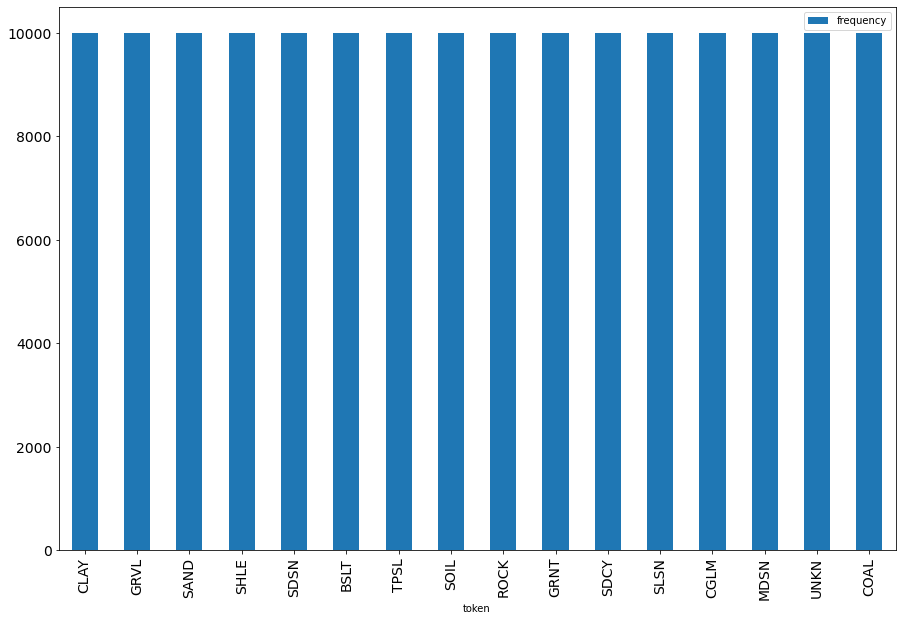

In [12]:
plot_freq(token_freq(balanced_litho_logs[MAJOR_CODE].values, 50))

### Dealing with imbalanced classes with weights

Instead of the resampling above, we adapt the approach creating weights for the Trainer we will run.


In [13]:
sorted_counts = litho_logs_kept[MAJOR_CODE].value_counts()
sorted_counts

CLAY    43526
GRVL    15824
SAND    15317
SHLE    10158
SDSN     9199
BSLT     7894
TPSL     5300
SOIL     4347
ROCK     2549
GRNT     1852
SDCY     1643
SLSN     1443
CGLM     1233
MDSN     1207
UNKN     1125
COAL     1040
Name: MajorLithCode, dtype: int64

In [14]:
sorted_counts / sorted_counts.sum()

CLAY    0.351990
GRVL    0.127967
SAND    0.123867
SHLE    0.082147
SDSN    0.074391
BSLT    0.063838
TPSL    0.042860
SOIL    0.035154
ROCK    0.020613
GRNT    0.014977
SDCY    0.013287
SLSN    0.011669
CGLM    0.009971
MDSN    0.009761
UNKN    0.009098
COAL    0.008410
Name: MajorLithCode, dtype: float64

In [15]:
class_weights = (1 - sorted_counts / sorted_counts.sum()).values
class_weights

array([0.64801022, 0.87203312, 0.87613317, 0.91785342, 0.92560874,
       0.93616213, 0.95713951, 0.96484631, 0.97938653, 0.98502309,
       0.98671325, 0.98833062, 0.99002887, 0.99023913, 0.99090225,
       0.99158964])

We check that cuda is available (of course optional)


In [16]:
assert torch.cuda.is_available()

On Linux if you have a DELL laptop with an NVIDIA card, but `nvidia-smi` returns: `NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running`, you may need to change your kernel specification file $HOME/.local/share/jupyter/kernels/hf/kernel.json. This behavior seems to depend on the version of Linux kernel you have. It certainly changed out of the blue for me from yesterday, despite no change that I can tell.

`optirun nvidia-smi` returning a proper graphic card report should be a telltale sign you have to update your kernel.json like so:

```json
{
 "argv": [
  "optirun",
  "/home/your_ident/miniconda/envs/hf/bin/python",
  "-m",
  "ipykernel_launcher",
  "-f",
  "{connection_file}"
 ],
 "display_name": "Hugging Face",
 "language": "python",
 "metadata": {
  "debugger": true
 }
}
```

You may need to restart jupyter-lab, or visual studio code, etc., for change to take effect. Restarting the kernel may not be enough, conter-intuitively.

Background details about optirun architecture at [Bumblebee Debian]https://wiki.debian.org/Bumblebee

In [17]:
class_weights = torch.from_numpy(class_weights).float().to("cuda")
class_weights

tensor([0.6480, 0.8720, 0.8761, 0.9179, 0.9256, 0.9362, 0.9571, 0.9648, 0.9794,
        0.9850, 0.9867, 0.9883, 0.9900, 0.9902, 0.9909, 0.9916],
       device='cuda:0')

In [18]:
model_nm = "microsoft/deberta-v3-small"

## Tokenisation

### Bump on the road; download operations taking too long

At this point I spent more hours than I wish I had on an issue, perhaps very unusual.

The operation `tokz = AutoTokenizer.from_pretrained(model_nm)` was taking an awful long time to complete:

```text
CPU times: user 504 ms, sys: 57.9 ms, total: 562 ms
Wall time: 14min 13s
```

To cut a long story short, I managed to figure out what was going on. It is documented on the Hugging Face forum at: [Some HF operations take an excessively long time to complete](https://discuss.huggingface.co/t/some-hf-operations-take-an-excessively-long-time-to-complete/18986). If you have issues where HF operations take a long time, read it.

Now back to the tokenisation story. Note that the local caching may be superflous if you do not encounter the issue just mentioned.

In [19]:
max_length = 128

In [20]:
p = Path("./tokz_pretrained")
pretrained_model_name_or_path = p if p.exists() else model_nm
# https://discuss.huggingface.co/t/sentence-transformers-paraphrase-minilm-fine-tuning-error/9612/4
tokz = AutoTokenizer.from_pretrained(pretrained_model_name_or_path, use_fast=True, max_length=max_length, model_max_length=max_length)
if not p.exists():
    tokz.save_pretrained("./tokz_pretrained")

Let's see what this does on a typical lithology description

In [21]:
tokz.tokenize("CLAY, VERY SANDY")

['▁C', 'LAY', ',', '▁VERY', '▁S', 'ANDY']

Well, the vocabulary is probably case sensitive and all the descriptions being uppercase in the source data are likely problematic. Let's check what happens on lowercase descriptions:

In [22]:
tokz.tokenize("clay, very sandy")

['▁clay', ',', '▁very', '▁sandy']

This looks better. So let's change the descriptions to lowercase; we are not loosing any relevent information in this case, I think.

In [23]:
# note: no warnings because we used .copy() earlier to create litho_logs_kept
litho_logs_kept[DESC] = litho_logs_kept[DESC].str.lower()

In [24]:
litho_logs_kept_mini = litho_logs_kept[[MAJOR_CODE_INT, DESC]]
litho_logs_kept_mini.sample(n=10)

,MajorLithoCodeInt,Description
8256,5,basalt
96820,4,sandstone
36776,2,sand
110231,0,"clay; light brown, very silty"
80270,1,gravel & large stones
17592,1,gravel water supply
74437,0,clay
22904,5,basalt stones
71578,1,gravel very clayey water supply
73030,3,shale


## Create dataset and tokenisation

We want to create a dataset such that tokenised data is of uniform shape (better for running on GPU)
Applying the technique in [this segment of the HF course video](https://youtu.be/_BZearw7f0w?list=PLo2EIpI_JMQvWfQndUesu0nPBAtZ9gP1o&t=150). Cheating a bit on guessing the length (I know from offline checks that max is 90 tokens)

In [25]:
ds = Dataset.from_pandas(litho_logs_kept_mini)

def tok_func(x):
    return tokz(
        x[DESC],
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )

The Youtube video above suggests to use `tok_ds = ds.map(tok_func, batched=True)` for a faster execution; however I ended up with the foollowing error:

```text
TypeError: Provided `function` which is applied to all elements of table returns a `dict` of types [<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]. When using `batched=True`, make sure provided `function` returns a `dict` of types like `(<class 'list'>, <class 'numpy.ndarray'>)`.
```

The following non-batched option works in a reasonable time:

In [26]:
tok_ds = ds.map(tok_func)

Parameter 'function'=<function tok_func at 0x7f0d047695e0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123657/123657 [00:24<00:00, 4962.06ex/s]


In [27]:
tok_ds_tmp = tok_ds[:5]
tok_ds_tmp.keys()

dict_keys(['MajorLithoCodeInt', 'Description', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'])

In [28]:
# check the length of vectors is indeed 128:
len(tok_ds_tmp["input_ids"][0][0])

128

In [29]:
num_labels = len(labels_kept)

In [30]:
# NOTE: the local caching may be superflous
p = Path("./model_pretrained")

model_name = p if p.exists() else model_nm
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, max_length=max_length)
                                                           # label2id=label2id, id2label=id2label).to(device) 
if not p.exists():
    model.save_pretrained(p)

In [31]:
print(type(model))

<class 'transformers.models.deberta_v2.modeling_deberta_v2.DebertaV2ForSequenceClassification'>


In [32]:
# Different approach, but one that I am not sure how to progress to a hugging face Dataset. Borrowed from [this video](https://youtu.be/1pedAIvTWXk?list=PLo2EIpI_JMQvWfQndUesu0nPBAtZ9gP1o&t=143)
# litho_desc_list = [x for x in litho_logs_kept_mini[DESC].values]
# input_descriptions = tokz(litho_desc_list, padding=True, truncation=True, max_length=256, return_tensors='pt')
# input_descriptions['input_ids'].shape
# model(input_descriptions['input_ids'][:5,:], attention_mask=input_descriptions['attention_mask'][:5,:]).logits

In [33]:
tok_ds

Dataset({
    features: ['MajorLithoCodeInt', 'Description', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 123657
})

Transformers always assumes that your labels has the column name "labels". Odd, but at least this fosters a consistent system, so why not:

In [34]:
tok_ds = tok_ds.rename_columns({MAJOR_CODE_INT: "labels"})

In [35]:
tok_ds = tok_ds.remove_columns(['Description', '__index_level_0__'])

In [36]:
# We want to make sure we work on the GPU, so at least make sure we have torch tensors.
# Note that HF is supposed to take care of movind data to the GPU if available, so you should not ahve to manually copy the data to the GPU device
tok_ds.set_format("torch")

In [37]:
# args = TrainingArguments(output_dir='./litho_outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
#     evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
#     num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [38]:
dds = tok_ds.train_test_split(0.25, seed=42)

In [39]:
dds.keys()

dict_keys(['train', 'test'])

In [40]:
tok_ds.features['labels'] = labels

In [41]:
tok_ds.features

# TODO:
#     This differs from chapter3 of HF course https://huggingface.co/course/chapter3/4?fw=pt    
# {'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
#  'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
#  'labels': ClassLabel(num_classes=2, names=['not_equivalent', 'equivalent'], id=None),
#  'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

{'labels': ClassLabel(num_classes=16, names=array(['CLAY', 'GRVL', 'SAND', 'SHLE', 'SDSN', 'BSLT', 'TPSL', 'SOIL',
        'ROCK', 'GRNT', 'SDCY', 'SLSN', 'CGLM', 'MDSN', 'UNKN', 'COAL'],
       dtype=object), id=None),
 'input_ids': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None)}

In [42]:
tok_ds['input_ids'][0]

[tensor([    1,  3592, 14432,  8076,     2,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [43]:
# https://huggingface.co/docs/transformers/training

In [44]:
# from Jeremy's notebook:
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

In [45]:
# Defining the Trainer to compute Custom Loss Function, adapted from [Simple Training with the 🤗 Transformers Trainer, around 840 seconds](https://youtu.be/u--UVvH-LIQ?t=840)
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Feed inputs to model and extract logits
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Extract Labels
        labels = inputs.get("labels")
        # Define loss function with class weights
        loss_func = torch.nn.CrossEntropyLoss(weight=class_weights)
        # Compute loss
        loss = loss_func(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [46]:
def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    predictions = eval_pred.predictions.argmax(-1)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"f1": f1}

In [47]:
output_dir = "./hf_training"
batch_size = 64 # 128
epochs = 5
lr = 8e-5

In [48]:
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=epochs,
    learning_rate=lr,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size * 2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_steps=len(dds["train"]),
    fp16=True,
    push_to_hub=False,
    report_to="none",
)

In [49]:
model = model.to("cuda:0")

The above nay not be strictly necessary, depending on your version of `transformers`. I bumped into the following issue, which was probably the transformers [4.11.3 bug](https://github.com/nlp-with-transformers/notebooks/issues/31#issuecomment-1075369210): `RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper__index_select)`

In [50]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dds["train"],
    eval_dataset=dds["test"],
    tokenizer=tokz,
    compute_metrics=compute_metrics,
)

Using amp half precision backend


## Training?

You did read the introduction and its spoiler alert, right? 

In [51]:
trainer.train()

/home/abcdef/miniconda/envs/hf/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 92742
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 7250


RuntimeError: The size of tensor a (768) must match the size of tensor b (128) at non-singleton dimension 3

# Stocktake and conclusion

So, as announced at the start of this post, we hit a pothole in our journey. 

```text
RuntimeError: The size of tensor a (768) must match the size of tensor b (128) at non-singleton dimension 3
```

Where the number (768) comes from is a bit of a mystery. I gather from Googling that this may have to do with the embedding of the Deberta model we are trying to fine tune, but I may be off the mark.

It is probably something at which an experience NLP practitioner will roll their eyes.

That's OK, We'll get there.